# Bias vs. Lead Time Plots

plotting the differnece between the AI forecast (Pangu-Weather) and ERA5 2 meter temperature reanalysis data as a function of of lead time.

These are global biases for now, but the intention is to focus on regions with higher biases and/or regions prone to/historically deal with sever weather/heat waves.

## Imports

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# Direct access
import s3fs # for models
import fsspec # for era5
# also install the package 'gcsfs' for google cloud storage, but importing is not necessary
import pandas as pd
# from io import BytesIO

# datetime
import datetime as dt

# api to read files
import dask.array as da
import xarray as xr
import h5py

# data process
import numpy as np
import pandas as pd

# plot
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Access google cloud storgate and read in ERA5

In [2]:
# https://storage.googleapis.com/gcp-public-data-arco-era5/raw/date-variable-single_level/2023/07/01/2m_temperature/surface.nc
# gcp-public-data-arco-era5/raw/date-variable-single_level/1940/01/01/2m_temperature

In [20]:
# Define the GCS path to the NetCDF file

year = '2023'
month = '07'
day = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
var = '2m_temperature'
# gcs_parent_path = 'gcp-public-data-arco-era5/raw/date-variable-single_level'

# Use fsspec to open the file
fs = fsspec.filesystem('gcs')

t2_list_era5 = []
for i in range(len(day)):
    gcs_path = f'gs://gcp-public-data-arco-era5/raw/date-variable-single_level/{year}/{month}/{day[i]}/{var}/surface.nc'
    
    # Open the NetCDF file using xarray
    with fs.open(gcs_path) as f:
        dataset = xr.open_dataset(f)

    if i == 0:
    
        lon_era = dataset.variables['longitude'][:]
        lat_era = dataset.variables['latitude'][:]
        era_time = dataset.variables['time'][:]

    t2_ERA5 = dataset.variables['t2m'][:]
    t2_list_era5.append(t2_ERA5)



## check the files

In [9]:
gcs_parent_path = 'gcp-public-data-arco-era5/raw/date-variable-single_level'
files = fs.ls(gcs_parent_path)

In [11]:
lon_era = dataset.variables['longitude'][:]
lat_era = dataset.variables['latitude'][:]
t2_ERA5 = dataset.variables['t2m'][:]
era_time = dataset.variables['time'][:]

## Access AWS servers and read in Pangu data

In [12]:
days = 10 
dd_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

s3 = s3fs.S3FileSystem(anon=True) # connect to s3

lon_list = []
lat_list = []
t2_list = []
time_list = []

for day in range(days):
    url_parents = 's3://noaa-oar-mlwp-data' 
    model = 'PANG_v100'
    yyyy = '2023'
    mm = '07'
    dd = dd_list[day]
    url_radar_search = url_parents +'/'+model+'/' +yyyy + '/' + mm + dd + '/'   
    
    url_radar_date = s3.ls(url_radar_search) # list all the files in the folder
    
    aws_file = 's3://' + url_radar_date[0]
    
    f = s3.open(aws_file, 'rb') # open the file
    
    ds = xr.open_dataset(f, chunks={'time': 10, 'lat': 50, 'lon': 50}, engine='h5netcdf') # read the file

    lon = ds.variables['longitude'][:]
    lon_list.append(lon)
    
    lat = ds.variables['latitude'][:]
    lat_list.append(lat)
    
    t2_PANG = ds.variables['t2'][:]
    t2_list.append(t2_PANG)
    
    time = ds.variables['time'][:]
    time_list.append(time)
    

In [13]:
time_list[5][16] # test to check if i loaded the data correctly, should read 2023-07-10 00 UTC

<xarray.Variable ()> Size: 8B
array('2023-07-10T00:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    long_name:  Date and Time

## ERA5 Reanalysis Data (Replaced by the cloud access from google cloud storage(GCS))

In [5]:
# era5_ds = xr.open_dataset('ERA5_data/20230701.part')
# lon_era = era5_ds.variables['longitude'][:]
# lat_era = era5_ds.variables['latitude'][:]
# t2_ERA5 = era5_ds.variables['t2m'][36,:,:]
# era_time =  era5_ds.variables['time'][36]
# t2_ERA5

<xarray.Variable (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Attributes:
    units:      K
    long_name:  2 metre temperature

In [14]:
datetime = pd.to_datetime(time_list[0].data, unit='s')
datetime

DatetimeIndex(['2023-07-01 00:00:00', '2023-07-01 06:00:00',
               '2023-07-01 12:00:00', '2023-07-01 18:00:00',
               '2023-07-02 00:00:00', '2023-07-02 06:00:00',
               '2023-07-02 12:00:00', '2023-07-02 18:00:00',
               '2023-07-03 00:00:00', '2023-07-03 06:00:00',
               '2023-07-03 12:00:00', '2023-07-03 18:00:00',
               '2023-07-04 00:00:00', '2023-07-04 06:00:00',
               '2023-07-04 12:00:00', '2023-07-04 18:00:00',
               '2023-07-05 00:00:00', '2023-07-05 06:00:00',
               '2023-07-05 12:00:00', '2023-07-05 18:00:00',
               '2023-07-06 00:00:00', '2023-07-06 06:00:00',
               '2023-07-06 12:00:00', '2023-07-06 18:00:00',
               '2023-07-07 00:00:00', '2023-07-07 06:00:00',
               '2023-07-07 12:00:00', '2023-07-07 18:00:00',
               '2023-07-08 00:00:00', '2023-07-08 06:00:00',
               '2023-07-08 12:00:00', '2023-07-08 18:00:00',
               '2023-07-

## Plots

In [18]:
# creating lead time markers for plot
LT_list = []
for day in range(days):
    LT = datetime[4*day]
    LT_list.append(LT)

In [19]:
LT_list

[Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-07-02 00:00:00'),
 Timestamp('2023-07-03 00:00:00'),
 Timestamp('2023-07-04 00:00:00'),
 Timestamp('2023-07-05 00:00:00'),
 Timestamp('2023-07-06 00:00:00'),
 Timestamp('2023-07-07 00:00:00'),
 Timestamp('2023-07-08 00:00:00'),
 Timestamp('2023-07-09 00:00:00'),
 Timestamp('2023-07-10 00:00:00')]

In [26]:
t2_list_era5[0].data[0,:,:]

(721, 1440)

In [75]:
# Calculate biases
bias_list = []
for day in range(days):
    bias = np.array(t2_list[day][36-(4*day)]) - t2_list_era5[0].data[0,:,:]
    bias_list.append(bias)

# Calculate average bias and variance
avg_bias_list = [np.mean(bias) for bias in bias_list]
var_bias_list = [np.var(bias) for bias in bias_list]

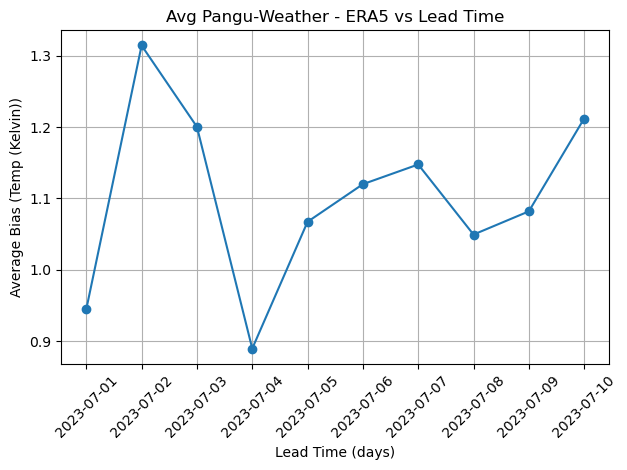

In [28]:
# Plot average bias
plt.figure()
plt.plot(LT_list, avg_bias_list, marker='o')
plt.xlabel('Lead Time (days)')
plt.ylabel('Average Bias (Temp (Kelvin))')
plt.title('Avg Pangu-Weather - ERA5 vs Lead Time')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

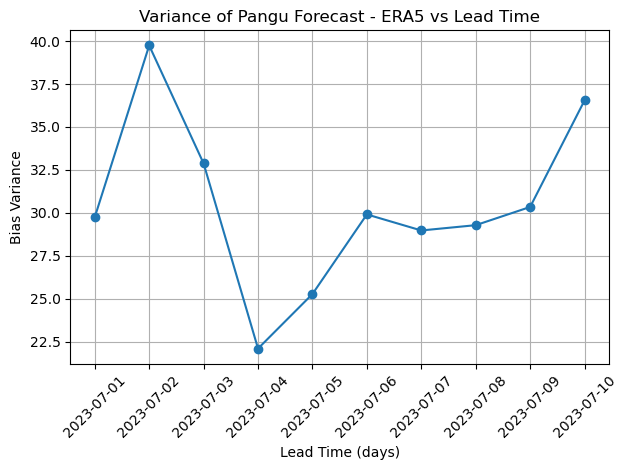

In [36]:
# Plot variance of bias
plt.figure()
plt.plot(LT_list, var_bias_list, marker='o')
plt.xlabel('Lead Time (days)')
plt.ylabel('Bias Variance')
plt.title('Variance of Pangu Forecast - ERA5 vs Lead Time')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [38]:
rmse_list = []
for day in range(days):
    rmse = np.sqrt((np.mean(np.array(t2_list[day][36-(4*day),:,:])- t2_list_era5[0].data[0,:,:])**2))
    rmse_list.append(rmse)
    
rmse_list

[0.9450711068914601,
 1.3141365952884974,
 1.2003037540258328,
 0.8899661689022947,
 1.0674071324998562,
 1.1200393995351832,
 1.1476083284135041,
 1.0495047012675431,
 1.0820054226621272,
 1.21192979042188]

In [76]:
bias_list[1]

array([[ 2.07022835e-01,  2.24173714e-01,  2.20114876e-01, ...,
        -6.23400059e-03, -9.28575840e-03, -4.02305826e-02],
       [ 2.95807668e-01,  3.60899545e-01,  3.67277719e-01, ...,
         7.82173358e-02,  1.04035207e-01,  7.89497577e-02],
       [ 4.69118087e-01,  4.74731204e-01,  4.98868491e-01, ...,
         2.56962001e-01,  2.81742275e-01,  2.58974044e-01],
       ...,
       [ 2.51972125e+01,  2.53676731e+01,  2.51926900e+01, ...,
         2.53607206e+01,  2.51399327e+01,  2.49606639e+01],
       [ 2.60628251e+01,  2.60059035e+01,  2.59088533e+01, ...,
         2.60894949e+01,  2.60079324e+01,  2.58676542e+01],
       [ 5.54548708e+01,  5.37641359e+01,  5.48521486e+01, ...,
         5.43403993e+01,  5.52928224e+01,  5.73900209e+01]])

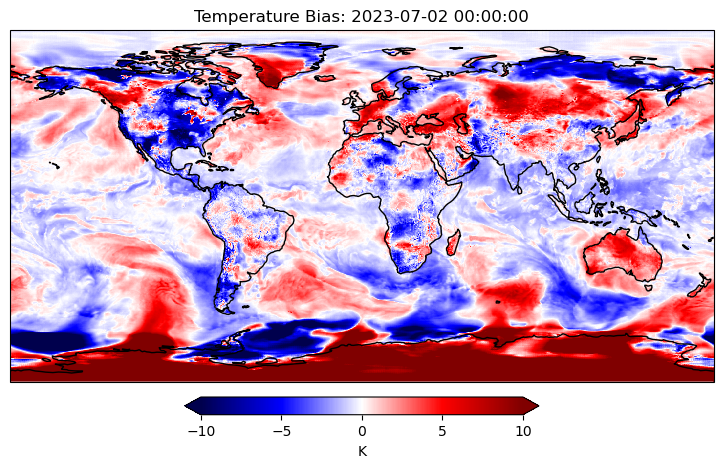

In [77]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
# ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')

# Create the contour plot with the 'jet' colormap
contour = ax.pcolormesh(lon, lat, bias_list[1], 
                        cmap='seismic', 
                        transform=ccrs.PlateCarree(),
                        vmin=-10, vmax=10, # fix the colorbar range
                        )

# Add the colorbar and set the label
cbar = plt.colorbar(contour,orientation='horizontal',
                    # cax=cbar_ax, 
                    fraction=0.046, pad=0.04,
                    # vmax=-10, vmin=10,   # fix the colorbar range
                    extend='both',  # make the colorbar ends pointy
                    )
cbar.set_label('K')
# set the sized of the colorbar
# cbar.ax.tick_params(labelsize=20)

plt.title(f'Temperature Bias: {str(LT_list[1])}')
plt.show()

### Figures to Pangu-Weather July 1st 2023 prediction of july 10 2023 

The idea is to create a subplot with the two figures you see below as a supplement to the plots from above.

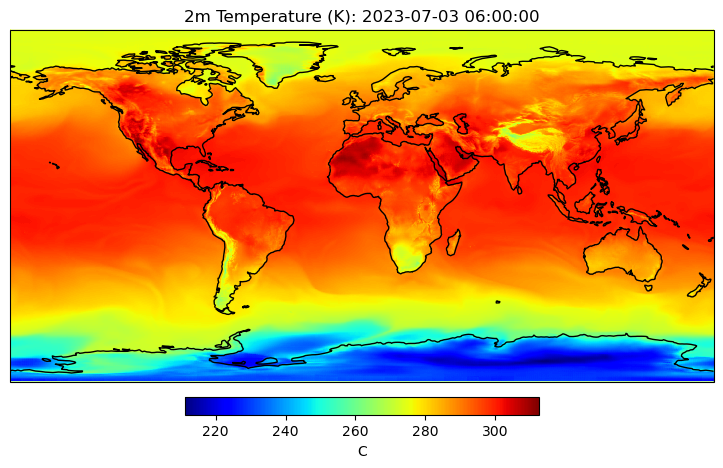

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
# ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')

# Create the contour plot with the 'jet' colormap
contour = ax.pcolormesh(lon, lat, t2_list[0][36,:,:], cmap='jet', transform=ccrs.PlateCarree())

# Add the colorbar and set the label
cbar = plt.colorbar(contour,orientation='horizontal',
                    # cax=cbar_ax, 
                    fraction=0.046, pad=0.04)
cbar.set_label('K')
# set the sized of the colorbar
# cbar.ax.tick_params(labelsize=20)

plt.title(f'2m Temperature (K): {str(datetime[9])}')
plt.show()

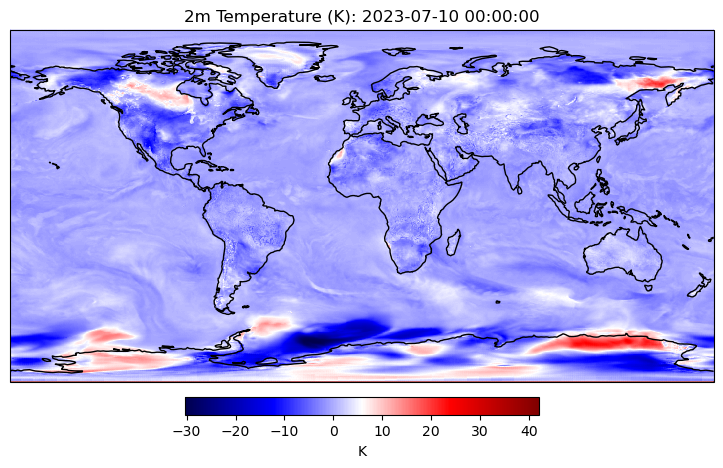

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Create the contour plot with the 'jet' colormap
contour = ax.pcolormesh(lon, lat, bias_list[0], cmap='seismic', transform=ccrs.PlateCarree())

# Add the colorbar and set the label
cbar = plt.colorbar(contour,orientation='horizontal',
                    # cax=cbar_ax, 
                    fraction=0.046, pad=0.04)
cbar.set_label('K')
# set the sized of the colorbar
# cbar.ax.tick_params(labelsize=20)

plt.title(f'2m Temperature (K): {str(datetime[36])}')
plt.show()

# LAND MASK

In [59]:
import cartopy.feature as cfeature
from shapely.geometry import Point, MultiPolygon
from shapely.vectorized import contains


In [112]:

# Create a land mask using Cartopy
land = cfeature.NaturalEarthFeature('physical', 'land', '110m')


## adjust lon from 0-360 to -180-180
lon_adj = np.array([i if i < 180 else i - 360 for i in lon])

# Generate a grid that matches your dataset
lon_grid, lat_grid = np.meshgrid(lon_adj, lat)

# # Initialize the land mask with zeros
# land_mask = np.zeros(lon_grid.shape, dtype=bool)

# Find shapefile for land 

- the following packages you can have try to read the certain mask: regionmask, catopy, global_land_mask
- you can also find shpefiles '.shp' and read the file, process the contain method using shapely pacakge. 

the key idea is to find out an interested shapefile, and use it for masking. 

In [113]:
# Use GSHHS dataset
land_feature = cfeature.GSHHSFeature(scale='high')

# Initialize the land mask with zeros
land_mask = np.zeros(lon_grid.shape, dtype=bool)

# Extract geometries from the land feature
land_geometries = list(land_feature.geometries())
# Create a MultiPolygon from the geometries
land_multipolygon = MultiPolygon(land_geometries)
# Check each point in the grid if it is in the land multipolygon
land_mask = contains(land_multipolygon, lon_grid, lat_grid)

In [114]:
land_temperature = np.where(land_mask, bias_list[1], np.nan)

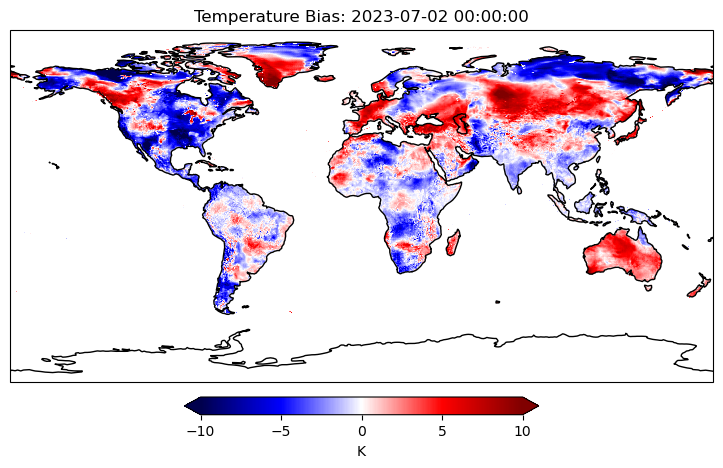

In [117]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
# ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')

# Create the contour plot with the 'jet' colormap
contour = ax.pcolormesh(lon_grid, lat_grid, land_temperature, 
                        cmap='seismic', 
                        transform=ccrs.PlateCarree(),
                        vmin=-10, vmax=10, # fix the colorbar range
                        )

# Add the colorbar and set the label
cbar = plt.colorbar(contour,orientation='horizontal',
                    # cax=cbar_ax, 
                    fraction=0.046, pad=0.04,
                    # vmax=-10, vmin=10,   # fix the colorbar range
                    extend='both',  # make the colorbar ends pointy
                    )
cbar.set_label('K')
# set the sized of the colorbar
# cbar.ax.tick_params(labelsize=20)

plt.title(f'Temperature Bias: {str(LT_list[1])}')
plt.show()